# Debugging and sanity checks of f4 ration Nea. estimates

In [1]:
suppressMessages({

library(tidyverse)
library(admixr)

source("../R/utils.R")

})

In [2]:
library(devtools)
reload(inst("admixr"))

Reloading installed admixr


In [3]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

<br><br><br>
## Old vs new processing of the Altai data

## Old Altai

In [4]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all//"
EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "UPA_merged")

In [5]:
s <- c("UstIshim", filter(samples, pop == "WestEurasia")$name)

### Use two individual f4 statistics to calculate the f4 ratio of Nea. ancestry

In [6]:
num_old <- qpDstat(W=s, X="Mbuti", Y="Altai", Z="Chimp",
                   prefix=EIGENSTRAT, dir_name="../admixtools/", f4mode=TRUE)

In [7]:
den_old <- qpDstat(W="new_Vindija", X="Mbuti", Y="Altai", Z="Chimp",
               prefix=EIGENSTRAT, dir_name="../admixtools/", f4mode=TRUE)

In [8]:
f4a_old <- mutate(num_old, alpha=Dstat/den_old$Dstat, name=W) %>% rename(admixtools_a=alpha)

### Merge this "manual" f4 ratio data.frame with the `qpF4ratio` results for the same setup

In [9]:
f4b_old  <- qpF4ratio(X=s, A="Altai", B="new_Vindija", C="Mbuti", O="Chimp",
                      prefix=EIGENSTRAT, dir_name="../admixtools") %>%
    rename(admixtools_b=alpha) %>% mutate(name=X)

### Plot the correlation of both

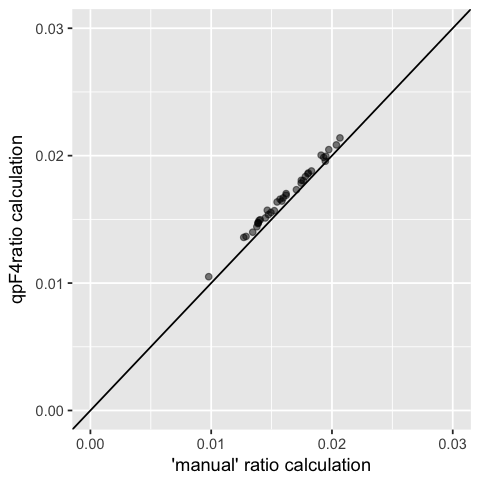

In [22]:
options(repr.plot.width=4, repr.plot.height=4)

inner_join(f4a_old, f4b_old, by="name") %>%
ggplot(aes(admixtools_a,  admixtools_b)) +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    coord_cartesian(x=c(0, 0.03), y=c(0, 0.03)) +
    labs(x="'manual' ratio calculation", y="qpF4ratio calculation")

## New Altai

In [11]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all//"
EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "UPA_merged_all")

In [12]:
s <- c("UstIshim", filter(samples, pop == "WestEurasia")$name)

### Use two individual f4 statistics to calculate the f4 ratio of Nea. ancestry

In [13]:
num <- qpDstat(W=s, X="Mbuti", Y="new_Altai", Z="Chimp",
               prefix=EIGENSTRAT, dir_name="../admixtools/", f4mode=TRUE)

In [14]:
den <- qpDstat(W="new_Vindija", X="Mbuti", Y="new_Altai", Z="Chimp",
               prefix=EIGENSTRAT, dir_name="../admixtools/", f4mode=TRUE)

In [15]:
f4a <- mutate(num, alpha=Dstat/den$Dstat, name=W) %>% rename(admixtools_a=alpha)

### Merge this "manual" f4 ratio data.frame with the `qpF4ratio` results for the same setup

In [16]:
f4b  <- qpF4ratio(X=s, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT, dir_name="../admixtools") %>%
    rename(admixtools_b=alpha) %>% mutate(name=X)

### Plot the correlation of both

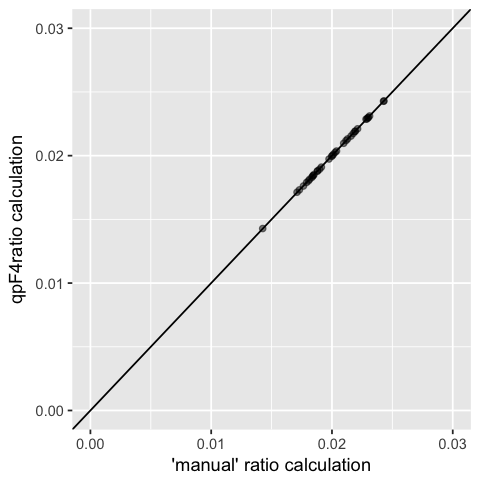

In [21]:
options(repr.plot.width=4, repr.plot.height=4)

inner_join(f4a, f4b, by="name") %>%
ggplot(aes(admixtools_a,  admixtools_b)) +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    coord_cartesian(x=c(0, 0.03), y=c(0, 0.03)) +
    labs(x="'manual' ratio calculation", y="qpF4ratio calculation")

In [54]:
suppressMessages({

steffi_df <- bind_rows(list(
    read_table2("../raw_data/steffi/results_usti_test/f4_ratios") %>% mutate(set="all"),
    read_table2("../raw_data/steffi/results_usti_test_array/f4_ratios") %>% mutate(set="array")
    )) %>% 
    filter(pop3 == "Altai", pop2 == "Mbuti") %>% 
    mutate(pop1=ifelse(pop1 == "Ust_Ishim", "UstIshim", pop1)) %>% 
    left_join(samples, by=c("pop1"="name")) %>%
    rename(name=pop1)

})

steffi_nea <- steffi_df %>% select(name, f4_ratio, set, pop) %>% spread(set, f4_ratio) %>%
    rename(steffi_all=all, steffi_array=array)

In [55]:
steffi_nea %>% head

name,pop,steffi_all,steffi_array
Abkhasian,WestEurasia,0.01993022,0.02001503
Adygei,WestEurasia,0.02330924,0.02563313
Albanian,WestEurasia,0.02408386,0.02671752
Aleut,CentralAsiaSiberia,0.02523005,0.02532569
Altaian,CentralAsiaSiberia,0.02613542,0.02702200
Ami,EastAsia,0.02532708,0.02458556


In [59]:
direct <- all_nea_estimates %>%
    filter(method == "direct") %>%
    select(name, pop, martin_direct=alpha)

f4 <- all_nea_estimates %>%
    filter(method == "qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp") %>%
    select(name, pop, martin_admixtools=alpha)

In [60]:
merged <- inner_join(direct, f4) %>% inner_join(steffi_nea)

Joining, by = c("name", "pop")
Joining, by = c("name", "pop")


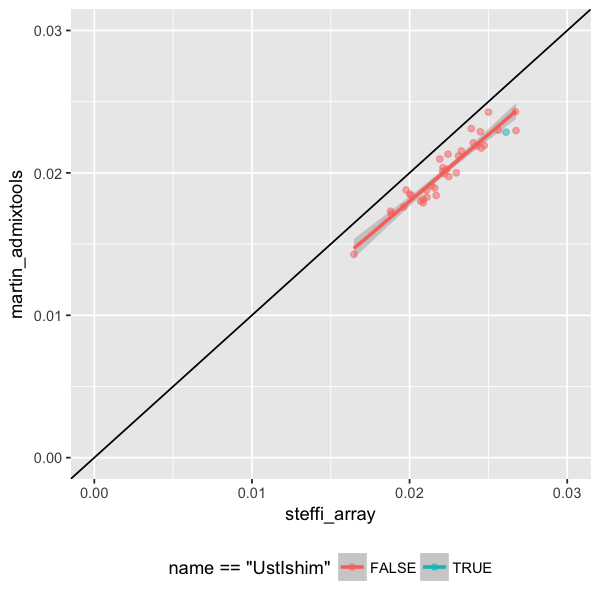

In [61]:
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res=120)

# using Vindja
ggplot(filter(merged, name == "UstIshim" | pop == "WestEurasia"),
       aes(steffi_array, martin_admixtools, color=name == "UstIshim")) +
    geom_smooth(method="lm") +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    xlim(0, 0.03) + ylim(0, 0.03) +
    theme(legend.position="bottom")

Using old Altai and new Vindija:

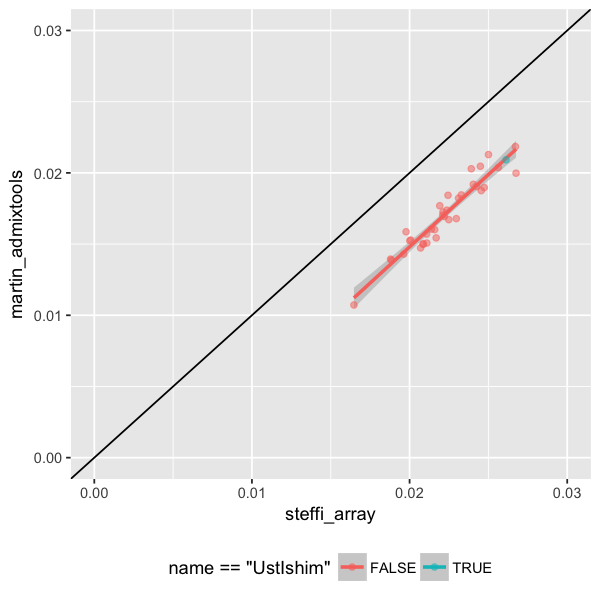

In [52]:
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res=120)

# using Vindja
ggplot(filter(merged, name == "UstIshim" | pop == "WestEurasia"),
       aes(steffi_array, martin_admixtools, color=name == "UstIshim")) +
    geom_smooth(method="lm") +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    xlim(0, 0.03) + ylim(0, 0.03) +
    theme(legend.position="bottom")